In [15]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imagehash

# Make the plots look highly professional
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 100

In [16]:
import os
import glob

# --- CONFIGURATION ---
HASH_FOLDER = "4855e8a491503f9eaa8624199ce1696f09d2fca701cdb7d6311725d153a803e4"
FRAMES_DIR = f".pipeline_cache/{HASH_FOLDER}/frames"

THRESHOLD = 5
ADAPTIVE_SPIKE = False  # Set to True if analyzing a scrolling terminal
SPIKE_DURATION = 3
MAX_STATIC = 30
FRAME_LIMIT = 100

print(f"Looking for images in: {os.path.abspath(FRAMES_DIR)}")

if not os.path.exists(FRAMES_DIR):
    print("❌ ERROR: That folder does not exist! Check the path above.")
else:
    frames = sorted(glob.glob(os.path.join(FRAMES_DIR, "*.jpg")))
    if FRAME_LIMIT > 0:
        frames = frames[:FRAME_LIMIT]
    print(f"✅ Loaded {len(frames)} frames for analysis.")

Looking for images in: /Users/gaurav/projects/no-source-control/video-multimodal-py/.pipeline_cache/4855e8a491503f9eaa8624199ce1696f09d2fca701cdb7d6311725d153a803e4/frames
✅ Loaded 100 frames for analysis.


In [20]:
data = []
last_hash = None
spike_counter = 0
frames_since_last_sent = 0

for frame_path in frames:
    frame_name = os.path.basename(frame_path)
    img = Image.open(frame_path)
    curr_hash = imagehash.dhash(img)

    if last_hash is None:
        data.append({"frame": frame_name, "distance": 0,
                    "status": "Kept (First)", "path": frame_path})
        last_hash = curr_hash
        continue

    dist = curr_hash - last_hash
    status = "Dropped (Similar)"

    # UNIFIED LOGIC BLOCK
    if dist > THRESHOLD:
        status = "Kept (Change Spike)"
        last_hash = curr_hash
        if ADAPTIVE_SPIKE:
            spike_counter = SPIKE_DURATION
        frames_since_last_sent = 0
    elif ADAPTIVE_SPIKE and spike_counter > 0:
        status = "Kept (Spike Falloff)"
        last_hash = curr_hash
        spike_counter -= 1
        frames_since_last_sent = 0
    elif frames_since_last_sent >= MAX_STATIC:
        status = "Kept (Heartbeat)"
        last_hash = curr_hash
        frames_since_last_sent = 0
    else:
        frames_since_last_sent += 1

    data.append({"frame": frame_name, "distance": dist,
                "status": status, "path": frame_path})

df = pd.DataFrame(data)
compression = (
    1 - (len(df[df['status'].str.contains('Kept')]) / len(df))) * 100
print(f"Simulated Compression: {compression:.1f}% frames dropped.")

Simulated Compression: 79.0% frames dropped.


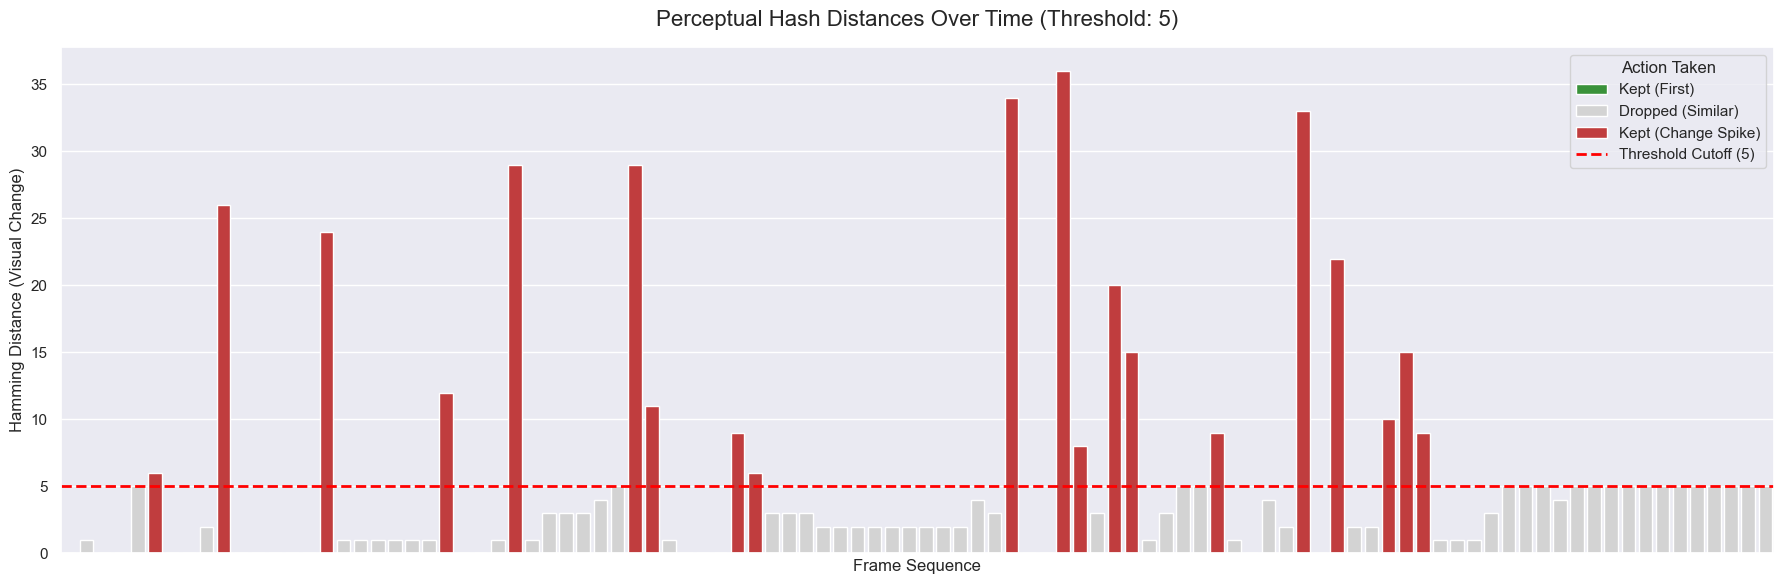

In [21]:
# Create the plot
plt.figure(figsize=(18, 6))

# Define custom colors for clarity
palette = {
    "Dropped (Similar)": "#d3d3d3",       # Light Grey
    "Kept (First)": "#2ca02c",            # Green
    "Kept (Change Spike)": "#d62728",     # Red
    "Kept (Spike Falloff)": "#ff7f0e",    # Orange
    "Kept (Heartbeat)": "#1f77b4"         # Blue
}

ax = sns.barplot(data=df, x='frame', y='distance',
                 hue='status', palette=palette, dodge=False)

# Add the threshold line
plt.axhline(y=THRESHOLD, color='red', linestyle='--',
            linewidth=2, label=f'Threshold Cutoff ({THRESHOLD})')

# Formatting
plt.title(
    f"Perceptual Hash Distances Over Time (Threshold: {THRESHOLD})", fontsize=16, pad=15)
plt.ylabel("Hamming Distance (Visual Change)", fontsize=12)
plt.xlabel("Frame Sequence", fontsize=12)

# Hide x-axis labels if there are too many frames to prevent crowding
if len(df) > 50:
    ax.set_xticks([])
else:
    plt.xticks(rotation=45, ha='right')

plt.legend(title="Action Taken", loc='upper right')
plt.tight_layout()
plt.show()

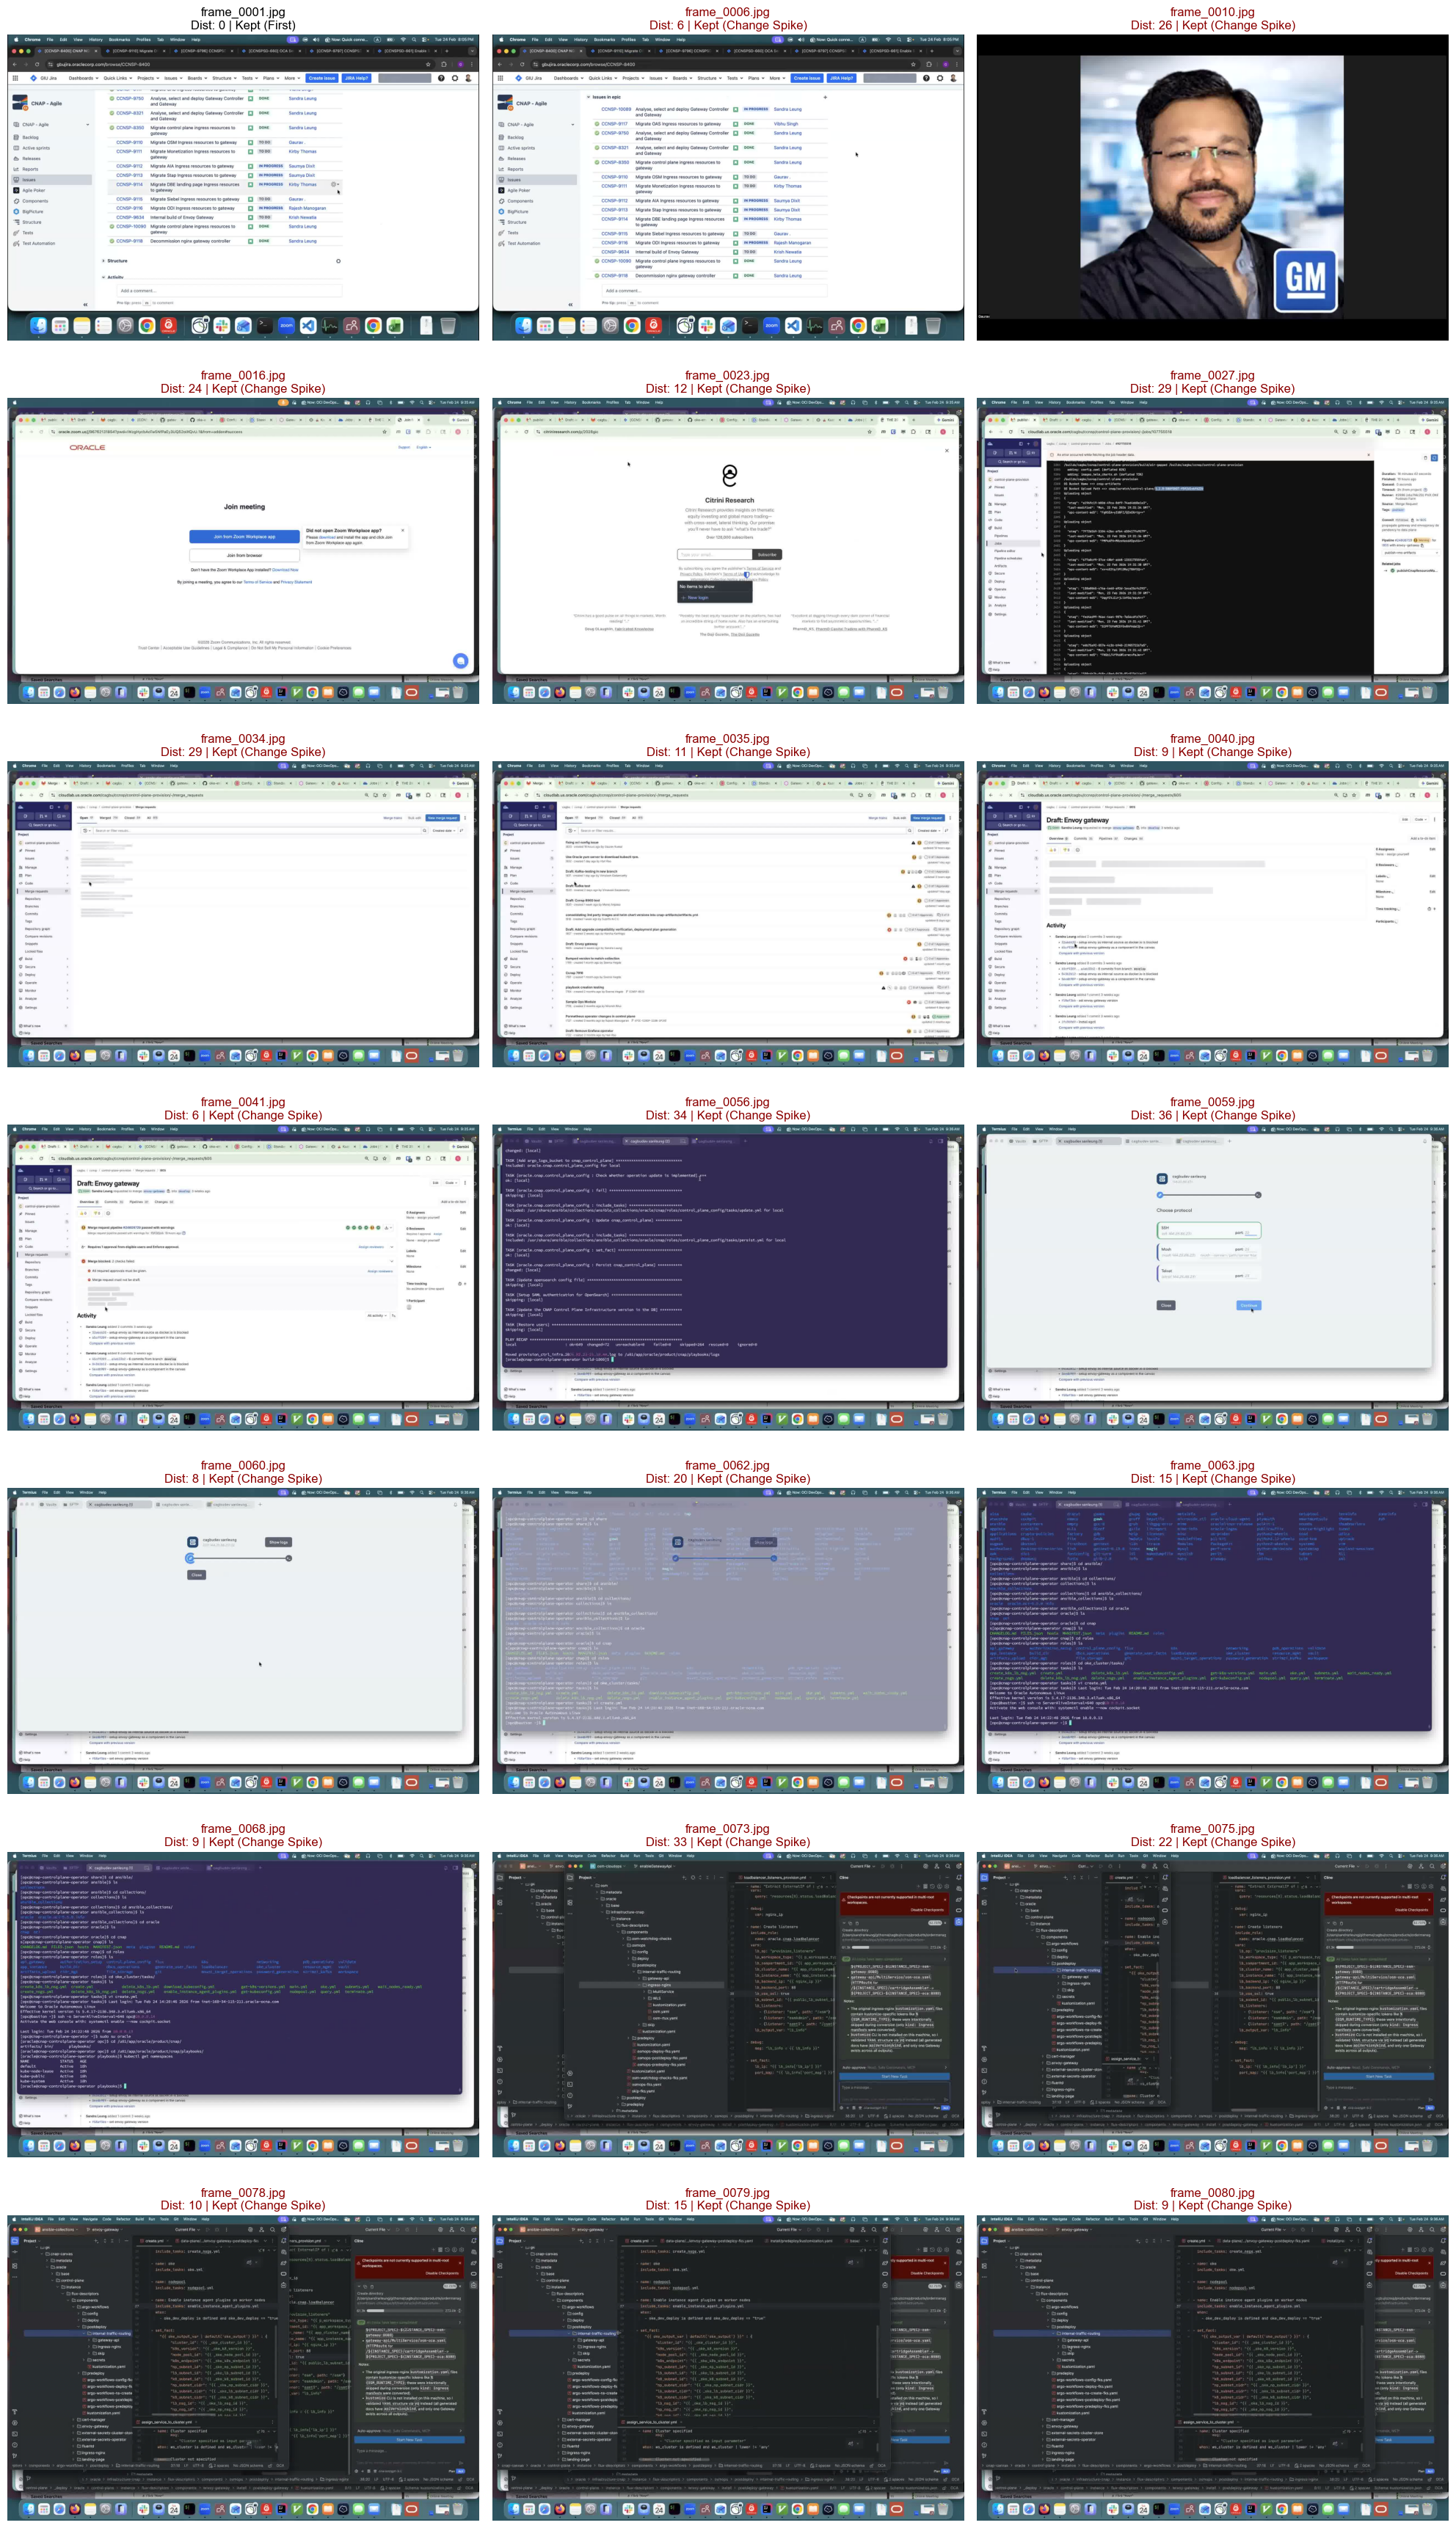

In [22]:
# Filter to only the frames the LLM would actually see
kept_frames = df[df['status'].str.contains('Kept')].reset_index(drop=True)

# Set up a grid (e.g., 3 columns wide)
cols = 3
rows = (len(kept_frames) // cols) + (1 if len(kept_frames) % cols > 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for idx, row in kept_frames.iterrows():
    img = Image.open(row['path'])
    ax = axes[idx]
    ax.imshow(img)

    # Add title with details
    title = f"{row['frame']}\nDist: {row['distance']} | {row['status']}"
    ax.set_title(title, fontsize=12,
                 color='darkred' if 'Spike' in row['status'] else 'black')
    ax.axis('off')

# Hide any empty subplots
for i in range(len(kept_frames), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Detailed Statistics
print("=" * 70)
print("PERCEPTUAL HASH ANALYSIS REPORT")
print("=" * 70)
print(f"\nTotal frames processed: {len(df)}")
print(f"Frames kept for LLM: {len(kept_frames)}")
print(f"Compression ratio: {compression:.1f}%")
print(f"\nThreshold used: {THRESHOLD}")
print(
    f"Hash distance range: {df['distance'].min():.0f} - {df['distance'].max():.0f}")
print(f"Average distance: {df['distance'].mean():.2f}")
print(f"Median distance: {df['distance'].median():.2f}")
print(f"Std deviation: {df['distance'].std():.2f}")
print("\nFrames by action:")
for status in df['status'].unique():
    count = len(df[df['status'] == status])
    pct = (count / len(df)) * 100
    print(f"  {status}: {count} ({pct:.1f}%)")

PERCEPTUAL HASH ANALYSIS REPORT

Total frames processed: 100
Frames kept for LLM: 21
Compression ratio: 79.0%

Threshold used: 5
Hash distance range: 0 - 36
Average distance: 5.45
Median distance: 3.00
Std deviation: 7.96

Frames by action:
  Kept (First): 1 (1.0%)
  Dropped (Similar): 79 (79.0%)
  Kept (Change Spike): 20 (20.0%)


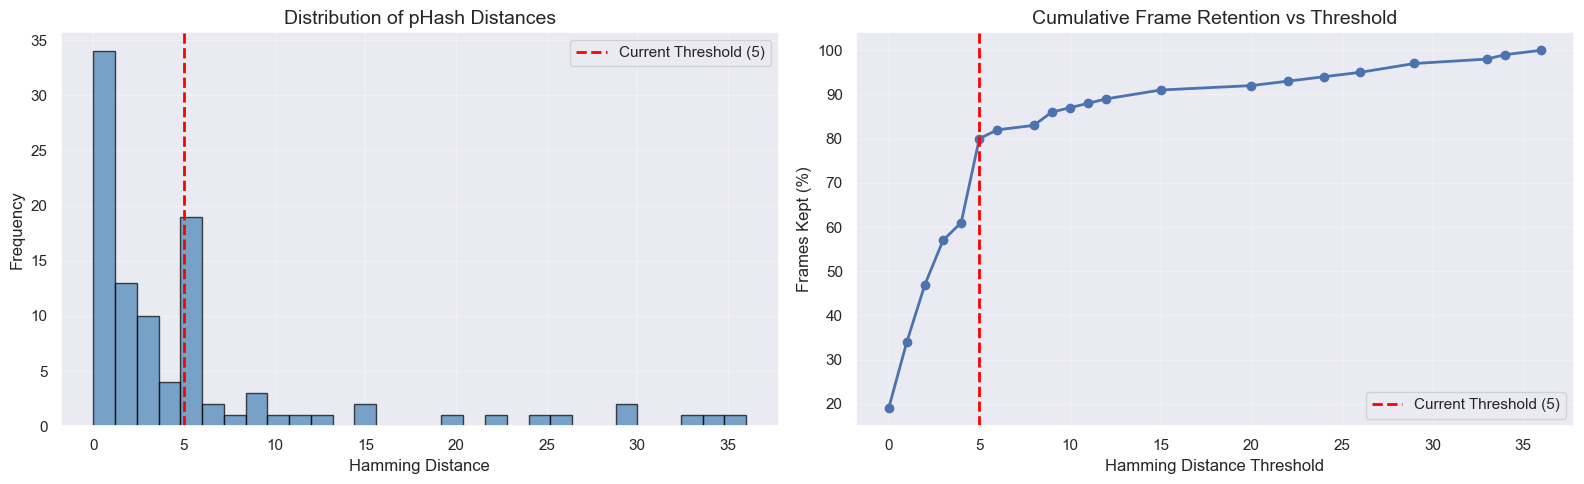

In [24]:
# Hash Distance Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of distances
axes[0].hist(df['distance'], bins=30, color='steelblue',
             edgecolor='black', alpha=0.7)
axes[0].axvline(THRESHOLD, color='red', linestyle='--',
                linewidth=2, label=f'Current Threshold ({THRESHOLD})')
axes[0].set_xlabel('Hamming Distance', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of pHash Distances', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Cumulative distribution
sorted_dist = sorted(df['distance'].unique())
cumulative = [len(df[df['distance'] <= d]) / len(df)
              * 100 for d in sorted_dist]
axes[1].plot(sorted_dist, cumulative, marker='o',
             linestyle='-', linewidth=2, markersize=6)
axes[1].axvline(THRESHOLD, color='red', linestyle='--',
                linewidth=2, label=f'Current Threshold ({THRESHOLD})')
axes[1].set_xlabel('Hamming Distance Threshold', fontsize=12)
axes[1].set_ylabel('Frames Kept (%)', fontsize=12)
axes[1].set_title('Cumulative Frame Retention vs Threshold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

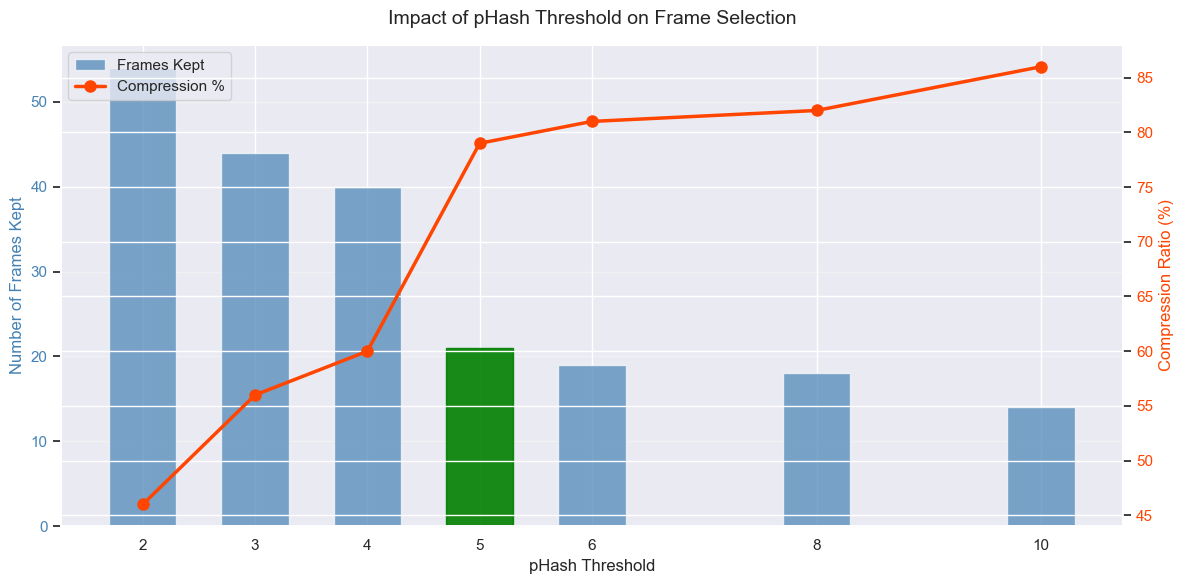


Threshold Comparison Table:
 Threshold  Frames Kept  Compression %
         2           54           46.0
         3           44           56.0
         4           40           60.0
         5           21           79.0
         6           19           81.0
         8           18           82.0
        10           14           86.0


In [25]:
# Threshold Comparison - Show impact of different thresholds
thresholds = [2, 3, 4, 5, 6, 8, 10]
results = []

for t in thresholds:
    kept_count = len(df[df['distance'] > t]) + 1  # +1 for first frame
    compression_pct = (1 - (kept_count / len(df))) * 100
    results.append({'Threshold': t, 'Frames Kept': kept_count,
                   'Compression %': compression_pct})

comparison_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Bar chart for frames kept
bars = ax.bar(comparison_df['Threshold'], comparison_df['Frames Kept'],
              color='steelblue', alpha=0.7, label='Frames Kept', width=0.6)
ax.set_xlabel('pHash Threshold', fontsize=12)
ax.set_ylabel('Number of Frames Kept', fontsize=12, color='steelblue')
ax.tick_params(axis='y', labelcolor='steelblue')

# Line chart for compression
line = ax2.plot(comparison_df['Threshold'], comparison_df['Compression %'],
                color='orangered', marker='o', linewidth=2.5, markersize=8, label='Compression %')
ax2.set_ylabel('Compression Ratio (%)', fontsize=12, color='orangered')
ax2.tick_params(axis='y', labelcolor='orangered')

# Highlight current threshold
current_idx = thresholds.index(THRESHOLD)
bars[current_idx].set_color('green')
bars[current_idx].set_alpha(0.9)

ax.set_title('Impact of pHash Threshold on Frame Selection',
             fontsize=14, pad=15)
ax.grid(alpha=0.3, axis='y')
ax.set_xticks(thresholds)

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print("\nThreshold Comparison Table:")
print(comparison_df.to_string(index=False))